In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold

In [117]:
file_path = '/content/drive/MyDrive/data_train-1.csv'

# Read the CSV file using pandas
df = pd.read_csv(file_path, index_col=0)

print(df.head())

    Loan_ID Gender Married Dependents Education Self_Employed  \
0  LP001518   Male     Yes          1  Graduate            No   
1  LP002734   Male     Yes          0  Graduate            No   
2  LP002697   Male      No          0  Graduate            No   
3  LP002455   Male     Yes          2  Graduate            No   
4  LP001732   Male     Yes          2  Graduate           NaN   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             1538             1425.0        30.0             360.0   
1             6133             3906.0       324.0             360.0   
2             4680             2087.0         NaN             360.0   
3             3859                0.0        96.0             360.0   
4             5000                0.0        72.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0         Urban           Y  
2             1.0     Semiurban           N 

The dataset contains information about loan applicants, including their gender, marital status, number of dependents, education level, self-employment status, income details (both applicant and co-applicant), loan amount, loan term, credit history, property area, and loan status (whether the loan was approved or not).

Here's a breakdown of the columns:

* Gender: The gender of the applicant (e.g., Male, Female)
* Married: Marital status of the applicant (e.g., Yes or No)
* Dependents: Number of dependents the applicant has (e.g., 0, 1, 2, 3+)
* Education: Level of education of the applicant (e.g., Graduate, Not Graduate)
* Self_Employed: Indicates if the applicant is self-employed (e.g., Yes or No)
* ApplicantIncome: Income of the applicant
* CoapplicantIncome: Income of the co-applicant
* LoanAmount: The amount of the loan requested by the applicant
* Loan_Amount_Term: The term or duration of the loan in months
* Credit_History: Indicates if the applicant has a credit history (e.g., 1 for Yes, 0 for No)
* Property_Area: Area where the property for which the loan is requested is located (e.g., Urban, Semiurban, Rural)
* Loan_Status: Indicates if the loan was approved (e.g., Y for Yes, N for No)

This dataset is related to loan applications and could be used for various analyses, such as predicting loan approval based on applicant characteristics, assessing the impact of different factors on loan approval, or identifying patterns in loan defaults.

In [118]:
# Shape of the Data
print("Shape of the DataFrame:", df.shape)

Shape of the DataFrame: (491, 13)


In [119]:
# Number of rows in each column with no Data
print(df.isnull().sum())

Loan_ID               0
Gender               12
Married               3
Dependents           13
Education             0
Self_Employed        29
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           17
Loan_Amount_Term     12
Credit_History       43
Property_Area         0
Loan_Status           0
dtype: int64


In [120]:
# New Shape of Train set
df = df.dropna()
print(df.shape)

(373, 13)


In [121]:
# Drop Loan Status as it is the label and Loan ID as it is just the ID and doesn't contribute in determining loan status
columns_to_drop = ['Loan_ID', 'Loan_Status']
features = df.drop(columns=columns_to_drop)
# Convert Credit History to string so that it is considered as categorial feature
features['Credit_History'] = features['Credit_History'].astype(str)
print('Features - ')
print(features.head())
print()
print()
# Create Label Data frame with column Loan Status
labels = df['Loan_Status']
print('Labels - ')
print(labels.head())

Features - 
  Gender Married Dependents     Education Self_Employed  ApplicantIncome  \
0   Male     Yes          1      Graduate            No             1538   
1   Male     Yes          0      Graduate            No             6133   
3   Male     Yes          2      Graduate            No             3859   
5   Male      No          0  Not Graduate           Yes             2583   
6   Male     Yes          0      Graduate            No             5829   

   CoapplicantIncome  LoanAmount  Loan_Amount_Term Credit_History  \
0             1425.0        30.0             360.0            1.0   
1             3906.0       324.0             360.0            1.0   
3                0.0        96.0             360.0            1.0   
5             2167.0       104.0             360.0            1.0   
6                0.0       138.0             360.0            1.0   

  Property_Area  
0         Urban  
1         Urban  
3     Semiurban  
5         Rural  
6         Rural  


Labels

In [122]:
cont_features = features.select_dtypes(include=[np.number])
print('Number of Continuous Features - ', cont_features.shape[1])
print('Continious Features - ', cont_features.columns)
print()
columns_to_exclude = cont_features.columns
cat_features = features.drop(columns=columns_to_exclude)
print('Number of Categorical Features - ', cat_features.shape[1])
print('Continious Features - ', cat_features.columns)

Number of Continuous Features -  4
Continious Features -  Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term'],
      dtype='object')

Number of Categorical Features -  7
Continious Features -  Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Credit_History', 'Property_Area'],
      dtype='object')


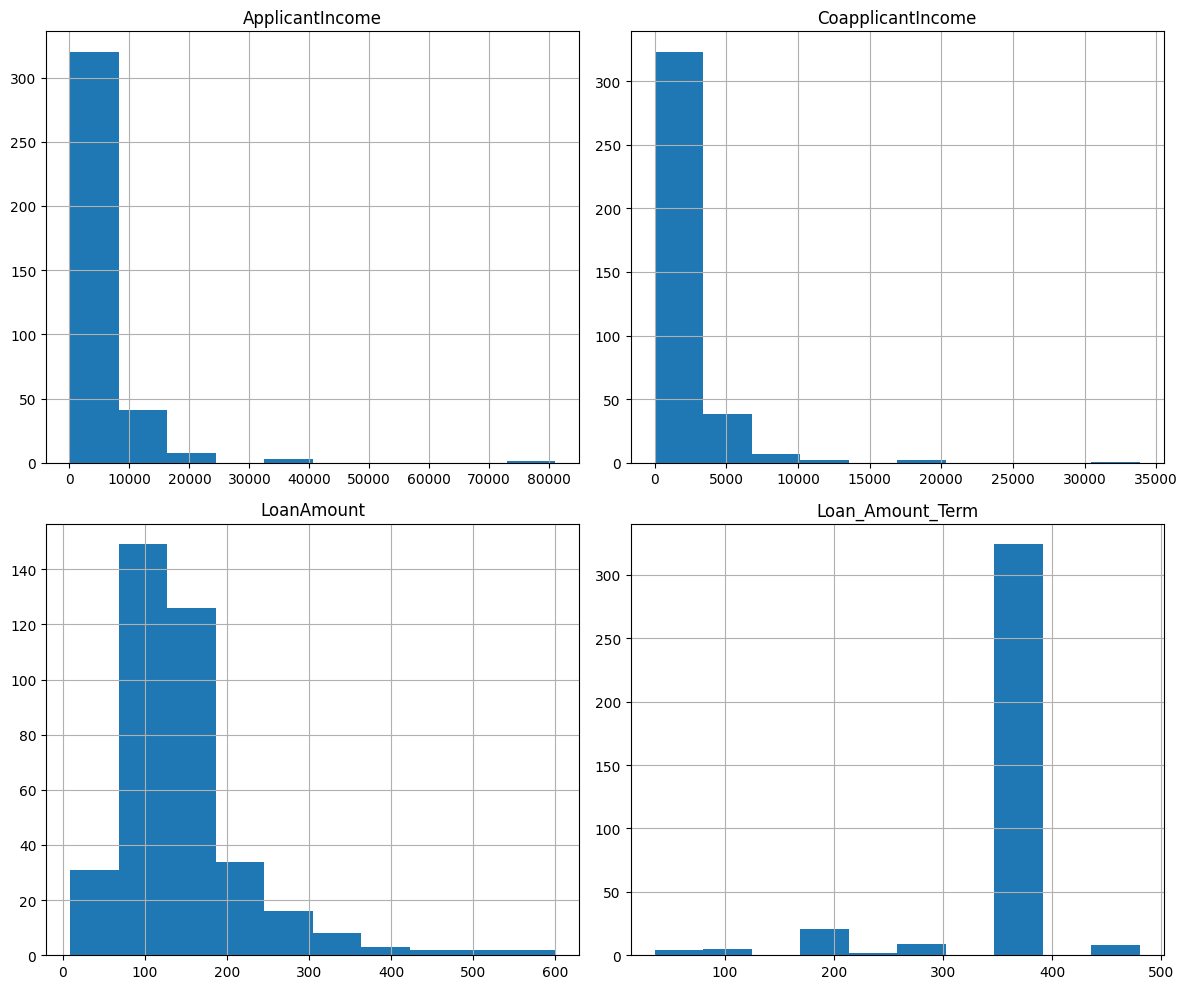

In [123]:
# The histogram plot for continious features
cont_features.hist(figsize=(12, 10))
plt.tight_layout()
plt.show()

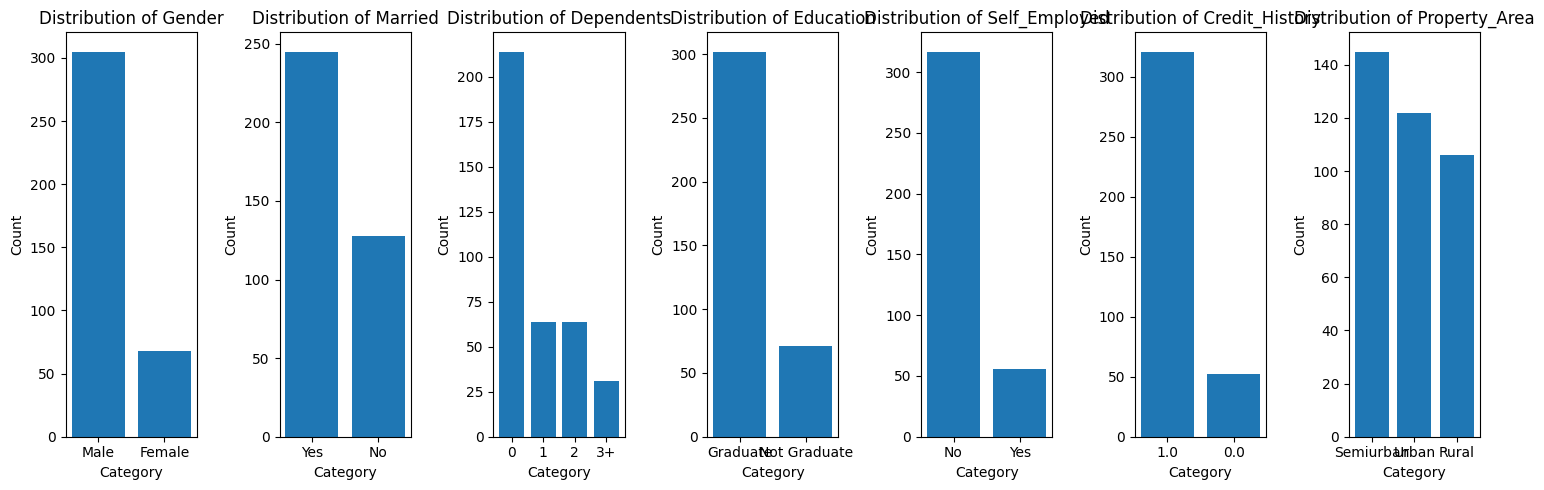

In [124]:
# The Bar Graph plot for Categorical Features
fig, axes = plt.subplots(nrows=1, ncols=len(cat_features.columns), figsize=(15, 5))

for i, column in enumerate(cat_features.columns):
    categories = cat_features[column].value_counts()
    axes[i].bar(categories.index, categories.values)
    axes[i].set_xlabel('Category')
    axes[i].set_ylabel('Count')
    axes[i].set_title(f'Distribution of {column}')

plt.tight_layout()
plt.show()

In [125]:
# Split the Training set to get training data set and validation data set
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=1)

In [126]:
class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        # Index of feature to split on
        self.feature_index = feature_index
        # Threshold value to split the feature
        self.threshold = threshold
        # Left child (subtree)
        self.left = left
        # Right child (subtree)
        self.right = right
        # Value if the node is a leaf
        self.value = value

class ClassificationTree:
    def __init__(self, max_depth=None, min_samples_split=1):
        # Maximum depth of the tree
        self.max_depth = max_depth
        # Minimum number of samples required to split a node
        self.min_samples_split = min_samples_split
        # Root node of the tree
        self.root = None

    # Model Fit Function
    def fit(self, X, y):
        self.root = self._grow_tree(X, y)
        return self.root

    # Grow tree function to populate the tree, based on max depth parameter
    def _grow_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape
        num_classes = len(np.unique(y))

        # Stopping criteria
        if (depth >= self.max_depth) or (num_classes == 1) or (num_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        # Find the best split
        best_feature_index, best_threshold = self._best_split(X, y)

        # Split the data based on best index
        if isinstance(X[0, best_feature_index], str):
            # Categorical split
            left_indices = [idx for idx, val in enumerate(X[:, best_feature_index]) if val == best_threshold]
            right_indices = [idx for idx in range(num_samples) if idx not in left_indices]
        else:
            # Continuous split
            left_indices = np.where(X[:, best_feature_index] <= best_threshold)[0]
            right_indices = np.where(X[:, best_feature_index] > best_threshold)[0]

        # Grow the tree by adding left and right child trees
        left_child = self._grow_tree(X[left_indices], y[left_indices], depth + 1)
        right_child = self._grow_tree(X[right_indices], y[right_indices], depth + 1)

        return Node(feature_index=best_feature_index, threshold=best_threshold, left=left_child, right=right_child)

    # With the number of sample available, find the best feature to split on
    def _best_split(self, X, y):
        num_samples, num_features = X.shape
        best_gini = float('inf')
        best_feature_index, best_threshold = None, None

        for feature_index in range(num_features):
            # Check if the feature is categorical
            if isinstance(X[0, feature_index], str):
                gini, thresholds = self._gini_categorical(X[:, feature_index], y)
                # Store the feature with best gini index
                if gini < best_gini:
                    best_gini = gini
                    best_feature_index = feature_index
                    best_threshold = thresholds
            # For Continious Features
            else:
                thresholds = np.unique(X[:, feature_index])
                thresholds = np.sort(thresholds)
                for i in range(len(thresholds) - 1):
                    # Thresholds is calculated using rolling average
                    threshold = (thresholds[i] + thresholds[i + 1]) / 2
                    left_indices = np.where(X[:, feature_index] <= threshold)[0]
                    right_indices = np.where(X[:, feature_index] > threshold)[0]
                    gini = self._gini_index(y[left_indices], y[right_indices])
                    # Store the feature with best gini index
                    if gini < best_gini:
                        best_gini = gini
                        best_feature_index = feature_index
                        best_threshold = threshold

        return best_feature_index, best_threshold

    # Calculate gini index for continious features based on feature splits
    def _gini_index(self, left_labels, right_labels):
        total_samples = len(left_labels) + len(right_labels)
        gini_left = 0.0 if len(left_labels) == 0 else self._gini(left_labels)
        gini_right = 0.0 if len(right_labels) == 0 else self._gini(right_labels)
        gini = (len(left_labels) / total_samples) * gini_left + (len(right_labels) / total_samples) * gini_right
        return gini

    # Calculate gini index for categorical features
    def _gini_categorical(self, feature_column, labels):
        classes = np.unique(feature_column)
        gini = float('inf')
        best_threshold = None
        for value in classes:
            indices = np.where(feature_column == value)[0]
            other_indices = np.where(feature_column != value)[0]
            gini_index = self._gini_index(labels[indices], labels[other_indices])
            if gini_index < gini:
                gini = gini_index
                best_threshold = value
        return gini, best_threshold

    # Calculate the gini indexes given the split
    def _gini(self, labels):
        classes, counts = np.unique(labels, return_counts=True)
        probabilities = counts / len(labels)
        gini = 1.0 - sum(probabilities ** 2)
        return gini

    # Most common label to determine the value of the leaf node
    # Count the number of Ys and Ns, which ever is more make it the value of leaf Node
    def _most_common_label(self, labels, indices=None):
        if indices is not None:
            labels_subset = labels[indices]
        else:
            labels_subset = labels
        labels_subset_numeric = np.where(labels_subset == 'Y', 1, 0)
        counts = np.bincount(labels_subset_numeric)
        most_common_label_numeric = np.argmax(counts)
        most_common_label = 'Y' if most_common_label_numeric == 1 else 'N'
        return most_common_label

    # Label prediction function
    def predict(self, X, rt):
        return np.array([self._predict_single(x, rt) for x in X])

    # For each set of features, iterate through the tree and determin the value
    def _predict_single(self, x, node):
        if node.value is not None:
            return node.value

        if x[node.feature_index] <= node.threshold:
            return self._predict_single(x, node.left)
        else:
            return self._predict_single(x, node.right)

    # Function to print the tree
    def print_tree(self):
      root=self.root
      q=[]
      q.append([root,-1])
      while len(q)!=0:
        n=q.pop(0)
        if n==None:
          continue
        print(features.columns[n[0].feature_index])
        print(n[0].feature_index)
        print(n[0].threshold)
        print(n[0].value)
        print(n[1])
        print()
        if n[0].left!=None:
          q.append([n[0].left, n[0].feature_index])
        if n[0].right!=None:
          q.append([n[0].right, n[0].feature_index])

In [127]:
# Class to calculate metrics to measure lof=gistic regression outputs
class calc_metrics:
  def __init__(self, y_p, y_t):
    self.y_t = y_t
    self.y_p = y_p
    self.tp = 0
    self.tn = 0
    self.fp = 0
    self.fn = 0
    for i in range(len(y_t)):
      if y_t[i]=='Y':
        if y_p[i]=='Y':
          self.tp+=1
        else:
          self.fn+=1
      if y_t[i]=='N':
        if y_p[i]=='N':
          self.tn+=1
        else:
          self.fp+=1
  def accuracy(self):
    return (self.tp + self.tn)/(self.tp + self.tn + self.fp + self.fn)
  def precision(self):
    return self.tp/(self.tp + self.fp)
  def recall(self):
    return self.tp/(self.tp + self.fn)
  def f1(self):
    return 2 * (self.precision()*self.recall())/(self.precision()+self.precision())

Maximum Depth Allowed -  1
Accuracy: 0.8
Precision: 0.7777777777777778
Recall: 0.98
F1 Score: 0.98
ROC AUC:  0.71

Maximum Depth Allowed -  2
Accuracy: 0.8
Precision: 0.7777777777777778
Recall: 0.98
F1 Score: 0.98
ROC AUC:  0.71

Maximum Depth Allowed -  3
Accuracy: 0.6933333333333334
Precision: 0.7547169811320755
Recall: 0.8
F1 Score: 0.8
ROC AUC:  0.64

Maximum Depth Allowed -  4
Accuracy: 0.7066666666666667
Precision: 0.75
Recall: 0.84
F1 Score: 0.84
ROC AUC:  0.6399999999999999

Maximum Depth Allowed -  5
Accuracy: 0.8
Precision: 0.7868852459016393
Recall: 0.96
F1 Score: 0.96
ROC AUC:  0.72

Maximum Depth Allowed -  6
Accuracy: 0.7733333333333333
Precision: 0.7894736842105263
Recall: 0.9
F1 Score: 0.9
ROC AUC:  0.71

Maximum Depth Allowed -  7
Accuracy: 0.7733333333333333
Precision: 0.7894736842105263
Recall: 0.9
F1 Score: 0.9
ROC AUC:  0.71

Maximum Depth Allowed -  8
Accuracy: 0.76
Precision: 0.7857142857142857
Recall: 0.88
F1 Score: 0.88
ROC AUC:  0.7

Maximum Depth Allowed -  9

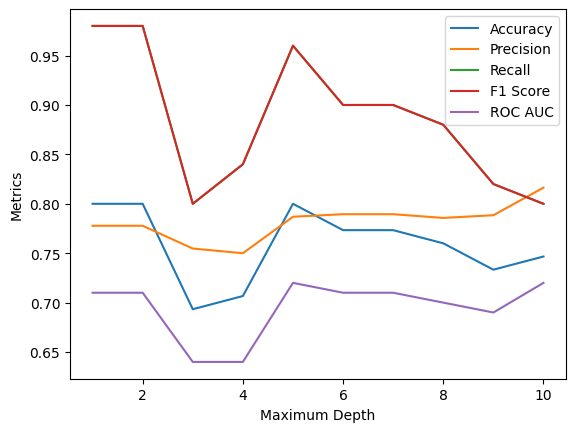

In [128]:
best_auc = float('-inf')
X = X_train
y = y_train
accuracies = []
precisions = []
recalls = []
f1_scores = []
roc_auc = []
depths = []
# Create decision tree with depth values from 1 - 10 and calculate metrics to determine it's performance
for depth in range(1,11):
    print('Maximum Depth Allowed - ', depth)
    class_tree = ClassificationTree(depth)
    depths.append(depth)

    root = class_tree.fit(X_train.values,y_train.values)
    y_pred = class_tree.predict(X_val.values, root)

    metrics = calc_metrics(y_pred, y_val.values)
    accuracies.append(metrics.accuracy())
    precisions.append(metrics.precision())
    recalls.append(metrics.recall())
    f1_scores.append(metrics.f1())
    # Convert it to 0s and 1s to calculate ROC AUC
    y_test = [1 if elem == 'Y' else 0 for elem in y_val.values]
    y_pred = [1 if elem == 'Y' else 0 for elem in y_pred]
    roc_auc.append(roc_auc_score(y_test, y_pred))
    # Store the root of the tree with the best ROC AUC value
    if roc_auc[depth-1] > best_auc:
      best_auc = roc_auc[depth-1]
      best_root = root

    print("Accuracy:", accuracies[depth-1])
    print("Precision:", precisions[depth-1])
    print("Recall:", recalls[depth-1])
    print("F1 Score:", f1_scores[depth-1])
    print("ROC AUC: ", roc_auc[depth-1])
    print()

plt.plot(depths, accuracies, label='Accuracy')
plt.plot(depths, precisions, label='Precision')
plt.plot(depths, recalls, label='Recall')
plt.plot(depths, f1_scores, label='F1 Score')
plt.plot(depths, roc_auc, label='ROC AUC')

plt.xlabel('Maximum Depth')
plt.ylabel('Metrics')
plt.legend()
plt.show()

In [129]:
# Split categorical features to add extra binary columns
cat_features = pd.get_dummies(cat_features)
features = pd.concat([cont_features, cat_features], axis=1)
print('Features - ')
print(features.head())
print()
# Map labels as 'Y' to 1 and 'N' to 0
labels = df['Loan_Status'].map({'Y': 1, 'N': 0})
print('Labels - ')
print(labels.head())

Features - 
   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             1538             1425.0        30.0             360.0   
1             6133             3906.0       324.0             360.0   
3             3859                0.0        96.0             360.0   
5             2583             2167.0       104.0             360.0   
6             5829                0.0       138.0             360.0   

   Gender_Female  Gender_Male  Married_No  Married_Yes  Dependents_0  \
0              0            1           0            1             0   
1              0            1           0            1             1   
3              0            1           0            1             0   
5              0            1           1            0             1   
6              0            1           0            1             1   

   Dependents_1  ...  Dependents_3+  Education_Graduate  \
0             1  ...              0                   1   
1         

In [130]:
# Split data to get training and validation set
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=1)

In [131]:
def train_XGBoost(X, y):
    # Given range of Lambda parameters
    lambda_params = [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]
    results = {}

    for lambda_param in lambda_params:
        # Library XG Boost model
        model = xgb.XGBClassifier(reg_lambda=lambda_param)

        # 10 fold cross-validation
        kf = KFold(n_splits=10, shuffle=True, random_state=42)
        aucs = []

        for train_index, test_index in kf.split(X):
          # Split data into train and test sets
          X_train, X_test = X[train_index], X[test_index]
          y_train, y_test = y[train_index], y[test_index]

          xg = model.fit(X_train, y_train)
          y_pred = model.predict(X_test)

          auc = roc_auc_score(y_test, y_pred)
          aucs.append(auc)

        mean_auc_score = np.mean(aucs)
        results[lambda_param] = mean_auc_score

    return results

X = X_train.values
y = y_train.values
results = train_XGBoost(X, y)
# Mean AUC of 10 fold cross validation
print(results)

{0.001: 0.6702183010768116, 0.01: 0.6615968809368493, 0.1: 0.6602618716366865, 1: 0.6622895179034632, 10.0: 0.6607018555658009, 100.0: 0.6952297090258122, 1000.0: 0.5}


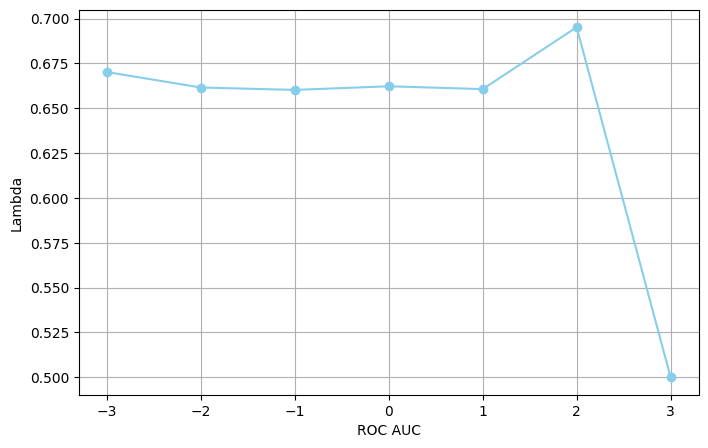

Best value of ROC AUC -  0.6952297090258122
Optimal Lambda -  100.0


In [132]:
best_lambda = float('-inf')
best_auc = float('-inf')
for lam, auc in results.items():
  if auc > best_auc:
    best_auc = auc
    best_lambda = lam

# Extract keys and values
lam = list(results.keys())
auc = list(results.values())
lam = [np.log10(key) for key in lam]
# Plot the graph
plt.figure(figsize=(8, 5))
plt.plot(lam, auc, marker='o', color='skyblue', linestyle='-')
plt.xlabel('ROC AUC')
plt.ylabel('Lambda')
plt.grid(True)
plt.show()

print('Best value of ROC AUC - ', best_auc)
print('Optimal Lambda - ', best_lambda)

The XG boost model is tested with given set of "L2 regularization term" values. After the L2 regularization term is set, 10 fold cross validation is done to split into training and test data. The ROC AUC values are generated for 10 folds and a mean value is calculated which stored against the L2 regularization term. The ROC AUC value is used to train the final model.

In [133]:
# The model with best ROC AUC values is chosen to train the final model
# The optimal Lambda is 100
best_model_xg = xgb.XGBClassifier(reg_lambda=best_lambda)
best_model_xg.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [134]:
from sklearn.metrics import roc_curve, auc
y_pred = best_model_xg.predict_proba(X_val)[:, 1]
# Compute false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
# Compute area under the curve (AUC)
roc_auc = auc(fpr, tpr)

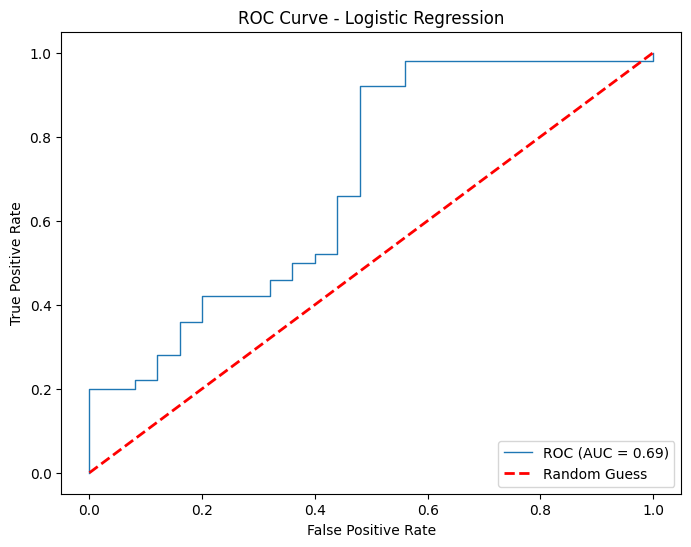

In [135]:
# Plot ROC curve for each fold
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=1, label='ROC (AUC = %0.2f)' % (roc_auc))

# Plot random guess line
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random Guess')

# Set plot labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.show()

In [136]:
# Load Test Data
file_path = '/content/drive/MyDrive/data_test-1.csv'

# Read the CSV file using pandas
test_df = pd.read_csv(file_path, index_col=0)

print(test_df.head())

    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP002364   Male     Yes          0      Graduate            No   
1  LP001334   Male     Yes          0  Not Graduate            No   
2  LP002979   Male     Yes         3+      Graduate            No   
3  LP002443   Male     Yes          2      Graduate            No   
4  LP001758   Male     Yes          2      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0            14880                0.0        96.0             360.0   
1             4188                0.0       115.0             180.0   
2             4106                0.0        40.0             180.0   
3             3340             1710.0       150.0             360.0   
4             6250             1695.0       210.0             360.0   

   Credit_History Property_Area  
0             1.0     Semiurban  
1             1.0     Semiurban  
2             1.0         Rural  
3             0.0     

In [137]:
# Drop rows with no data
test_df = test_df.dropna()

In [138]:
# Drop Loan ID from test set
columns_to_drop = ['Loan_ID']
test_features = test_df.drop(columns=columns_to_drop)
# Convert credit history to string
test_features['Credit_History'] = test_features['Credit_History'].astype(str)
print(test_features.head())

  Gender Married Dependents     Education Self_Employed  ApplicantIncome  \
0   Male     Yes          0      Graduate            No            14880   
1   Male     Yes          0  Not Graduate            No             4188   
2   Male     Yes         3+      Graduate            No             4106   
3   Male     Yes          2      Graduate            No             3340   
4   Male     Yes          2      Graduate            No             6250   

   CoapplicantIncome  LoanAmount  Loan_Amount_Term Credit_History  \
0                0.0        96.0             360.0            1.0   
1                0.0       115.0             180.0            1.0   
2                0.0        40.0             180.0            1.0   
3             1710.0       150.0             360.0            0.0   
4             1695.0       210.0             360.0            1.0   

  Property_Area  
0     Semiurban  
1     Semiurban  
2         Rural  
3         Rural  
4     Semiurban  


In [139]:
# Train the decision tree with root with best ROC AUC value
decision_tree = class_tree.predict(test_features.values, best_root)

In [140]:
# Split categorical test features to add extra binary columns
test_cont_features = test_features.select_dtypes(include=[np.number])
columns_to_exclude = cont_features.columns
test_cat_features = test_features.drop(columns=columns_to_exclude)
test_cat_features = pd.get_dummies(test_cat_features)
test_features = pd.concat([test_cont_features, test_cat_features], axis=1)
print(test_features.head())

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0            14880                0.0        96.0             360.0   
1             4188                0.0       115.0             180.0   
2             4106                0.0        40.0             180.0   
3             3340             1710.0       150.0             360.0   
4             6250             1695.0       210.0             360.0   

   Gender_Female  Gender_Male  Married_No  Married_Yes  Dependents_0  \
0              0            1           0            1             1   
1              0            1           0            1             1   
2              0            1           0            1             0   
3              0            1           0            1             0   
4              0            1           0            1             0   

   Dependents_1  ...  Dependents_3+  Education_Graduate  \
0             0  ...              0                   1   
1             0  ...  

In [141]:
# Predict labels for test data
xg_out = best_model_xg.predict(test_features.values)
xg_output = []
for i in range(len(xg_out)):
  if xg_out[i] == 1:
    xg_output.append('Y')
  else:
    xg_output.append('N')

In [142]:
# Add the 2 predicted outputs to CSV
import csv

data = zip(decision_tree, xg_output)

csv_filename = '/content/drive/MyDrive/Pavan Santosh_Nippani Ravi_preds.csv'

fieldnames = ['pred_tree', 'pred xgboost']

# Write data to CSV file
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fieldnames)

    writer.writeheader()

    for row in data:
        writer.writerow({fieldnames[0]: row[0], fieldnames[1]: row[1]})

print(f"CSV file '{csv_filename}' has been created successfully.")

CSV file '/content/drive/MyDrive/Pavan Santosh_Nippani Ravi_preds.csv' has been created successfully.
